In [12]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
JSON_PATH="features.json"

In [14]:
with open(JSON_PATH, "r") as fp:
    data = json.load(fp)

    x = np.array(data["MFCCs"])
    y = np.array(data["labels"])

In [15]:
    
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [16]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [17]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

input_shape 

(44, 13, 1)

In [18]:
model= tf.keras.Sequential()
 
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(tf.keras.layers.BatchNormalization())


model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(tf.keras.layers.BatchNormalization())


model.add(tf.keras.layers.Conv2D(64, (2, 2), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(9, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))


model.add(tf.keras.layers.Dense(9, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 42, 11, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 6, 16)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 21, 6, 16)        64        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 19, 4, 32)         4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 2, 32)        0         
 2D)                                                             
                                                      

In [19]:
monitor = EarlyStopping(monitor='val_loss', patience=10, 
                        verbose=1, mode='min',restore_best_weights=True)


filepath = './pemsuModel.hdf5'
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint,monitor]

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [20]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=150, callbacks=callback_list)

Epoch 1/150
1/9 [==>...........................] - ETA: 4s - loss: 2.6457 - accuracy: 0.0625
Epoch 1: val_loss improved from inf to 2.28717, saving model to .\pemsuModel.hdf5
9/9 [==============================] - 1s 36ms/step - loss: 2.0956 - accuracy: 0.2158 - val_loss: 2.2872 - val_accuracy: 0.2000
Epoch 2/150
1/9 [==>...........................] - ETA: 0s - loss: 1.8259 - accuracy: 0.2188
Epoch 2: val_loss improved from 2.28717 to 2.10252, saving model to .\pemsuModel.hdf5
9/9 [==============================] - 0s 15ms/step - loss: 1.6892 - accuracy: 0.3669 - val_loss: 2.1025 - val_accuracy: 0.2286
Epoch 3/150
1/9 [==>...........................] - ETA: 0s - loss: 1.5413 - accuracy: 0.3125
Epoch 3: val_loss improved from 2.10252 to 2.08702, saving model to .\pemsuModel.hdf5
9/9 [==============================] - 0s 15ms/step - loss: 1.4194 - accuracy: 0.4137 - val_loss: 2.0870 - val_accuracy: 0.2429
Epoch 4/150
1/9 [==>...........................] - ETA: 0s - loss: 1.1746 - accurac

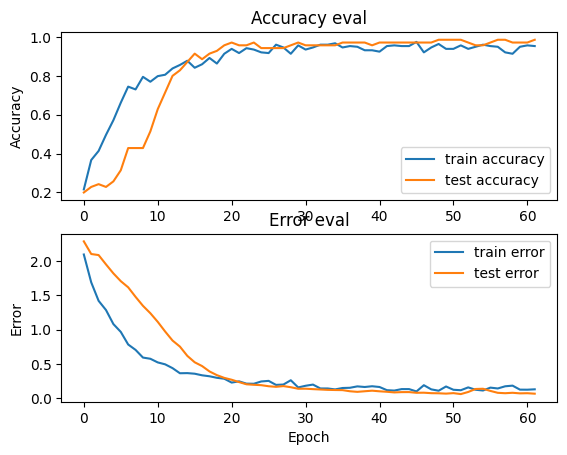

In [23]:
plot_history(history)

from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from tensroflow import load_model
model = load_model('pemsuModel.hdf5')

ModuleNotFoundError: No module named 'tensroflow'

In [1]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

X_to_predict = X_test
y_to_predict = y_test

X = X_to_predict.reshape(-1, 44, 13, 1)

prediction = model.predict(X)

predicted_index = np.argmax(prediction, axis=1)

# print("Target: {}, Predicted label: {}".format(y_to_predict, predicted_index))

precision = precision_score(y_to_predict, predicted_index, average='macro')
recall = recall_score(y_to_predict, predicted_index, average='macro')
f1 = f1_score(y_to_predict, predicted_index, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


NameError: name 'model' is not defined

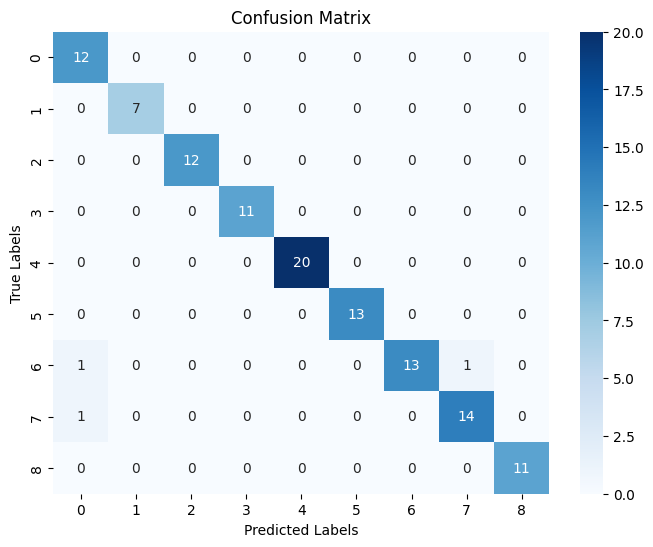

In [28]:
cm = confusion_matrix(y_to_predict, predicted_index)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()